In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import count
from scipy import ndimage
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm
import tensorflow_addons as tfa

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 28
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_augment"
PATH = ""

# Set seeds

In [0]:
np.random.seed(3)
tf.random.set_seed(3)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

4423680/4422102 [==============================] - 2s 1us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def FashionMNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = "same")(x)
    x = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters = 10, kernel_size = (1,1),strides = (1,1), padding = 'valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Data augmentation functions


In [0]:
def flip_image(image):
    if np.random.rand() < 0.2:
        image = tf.image.flip_left_right(image)
    return image

In [0]:
def rotate_image(image):
    if np.random.rand() < 0.2:
        angles = np.linspace(1,10,10)
        rotation_angle = np.random.choice(angles)
        if np.random.rand() < 0.5:
            image = ndimage.rotate(image, rotation_angle, reshape = False)
        else:
            image = ndimage.rotate(image, -rotation_angle, reshape = False) 
    return image

In [0]:
def horizontal_shift(image):
    if np.random.rand() < 0.2:
        num_rows, num_cols = image.shape[:2]
        if np.random.rand() < 0.5:
            translation_matrix = np.float32([ [1,0,3], [0,1,0] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        else:
            translation_matrix = np.float32([ [1,0,-3], [0,1,0] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
    return image

In [0]:
def vertical_shift(image):
    if np.random.rand() < 0.2:
        num_rows, num_cols = image.shape[:2]
        if np.random.rand() < 0.5:
            translation_matrix = np.float32([ [1,0,0], [0,1,2] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        else:
            translation_matrix = np.float32([ [1,0,0], [0,1,-2] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
    return image

In [0]:
funcs = [rotate_image,
         horizontal_shift, 
         vertical_shift]

# Train

In [16]:
models = []
accuracies = [0]

for i in range(len(funcs)):

    print(f"Train model {i}")

    preprocessing_function = funcs[i]
    datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    datagen = datagen.flow(x_train,y_train, batch_size = BATCH_SIZE)

    model = FashionMNISTmodel(IMAGE_SIZE, NUM_CLASSES, 1)

    es = EarlyStopping(min_delta = 0.01, patience=3)
    model.fit_generator(datagen,
                        epochs = EPOCHS,
                        validation_data = (x_test,y_test),
                        shuffle = True,
                        callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")

Train model 0
Epoch 1/9999
375/375 [==============================] - 11s 30ms/step - loss: 2.1619 - accuracy: 0.2397 - val_loss: 2.1878 - val_accuracy: 0.2723
Epoch 2/9999
375/375 [==============================] - 5s 13ms/step - loss: 1.9125 - accuracy: 0.3683 - val_loss: 1.8190 - val_accuracy: 0.3847
Epoch 3/9999
375/375 [==============================] - 5s 13ms/step - loss: 1.6876 - accuracy: 0.4320 - val_loss: 1.5821 - val_accuracy: 0.4754
Epoch 4/9999
375/375 [==============================] - 5s 13ms/step - loss: 1.5228 - accuracy: 0.5050 - val_loss: 1.4442 - val_accuracy: 0.5405
Epoch 5/9999
375/375 [==============================] - 5s 13ms/step - loss: 1.4059 - accuracy: 0.5491 - val_loss: 1.3467 - val_accuracy: 0.5682
Epoch 6/9999
375/375 [==============================] - 5s 13ms/step - loss: 1.3179 - accuracy: 0.5764 - val_loss: 1.2698 - val_accuracy: 0.5885
Epoch 7/9999
375/375 [==============================] - 5s 12ms/step - loss: 1.2499 - accuracy: 0.5931 - val_loss: 

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Model: 0 added. Resulting score: 0.7530833333333333
Train model 1
Epoch 1/9999
375/375 [==============================] - 3s 8ms/step - loss: 2.1875 - accuracy: 0.2132 - val_loss: 2.1843 - val_accuracy: 0.3066
Epoch 2/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.9343 - accuracy: 0.3675 - val_loss: 1.8276 - val_accuracy: 0.4026
Epoch 3/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.7034 - accuracy: 0.4450 - val_loss: 1.5945 - val_accuracy: 0.4902
Epoch 4/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.5282 - accuracy: 0.4992 - val_loss: 1.4453 - val_accuracy: 0.5313
Epoch 5/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.4058 - accuracy: 0.5437 - val_loss: 1.3454 - val_accuracy: 0.5604
Epoch 6/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.3201 - accuracy: 0.5699 - val_loss: 1.2681 - val_accuracy: 0.5905
Epoch 7/9999
375/375 [==============================] - 3s 7ms/step - 

100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Model: 1 added. Resulting score: 0.7515833333333334
Train model 2
Epoch 1/9999
375/375 [==============================] - 3s 7ms/step - loss: 2.1994 - accuracy: 0.2407 - val_loss: 2.1912 - val_accuracy: 0.3582
Epoch 2/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.9060 - accuracy: 0.4204 - val_loss: 1.7965 - val_accuracy: 0.4541
Epoch 3/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.6806 - accuracy: 0.4940 - val_loss: 1.5737 - val_accuracy: 0.5236
Epoch 4/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.5174 - accuracy: 0.5393 - val_loss: 1.4378 - val_accuracy: 0.5631
Epoch 5/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.3987 - accuracy: 0.5670 - val_loss: 1.3396 - val_accuracy: 0.5835
Epoch 6/9999
375/375 [==============================] - 3s 7ms/step - loss: 1.3093 - accuracy: 0.5907 - val_loss: 1.2686 - val_accuracy: 0.5851
Epoch 7/9999
375/375 [==============================] - 3s 7ms/step - 

100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

Model: 2 added. Resulting score: 0.765


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensemble

In [17]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.000000,0
1,0.753083,1
2,0.751583,2
3,0.765000,3


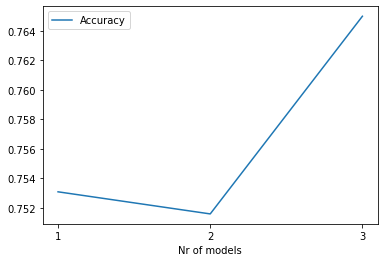

In [18]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [19]:
print("Accuracy: " + str(predict(models, x_test, y_test)))

100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

Accuracy: 0.7604


In [20]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))



100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


## Correlation between models

In [21]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,np.argmax(y_test, axis = 1))])

100%|██████████| 3/3 [00:00<00:00, 346.30it/s]


In [22]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2
0,NaN,0.896291,0.900179
1,0.896291,NaN,0.893928
2,0.900179,0.893928,NaN


Average correlation: 0.8967991064158763
